In [100]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy import interpolate
import math
from ipywidgets import *

# use engauge to extract plot data from datasheet
fn = "25L6GT EC2=110V.csv"
df = pd.read_csv(fn)

In [101]:
df.head(1)

,AnodeVoltage,0V,-2V,-4V,-6V,-8V,-10V,-12V,-14V,-16V
0,0,0.00035,-0.00034,-0.00069,0.00035,0.00241,0.00034,-0.00069,0.00414,0.00034


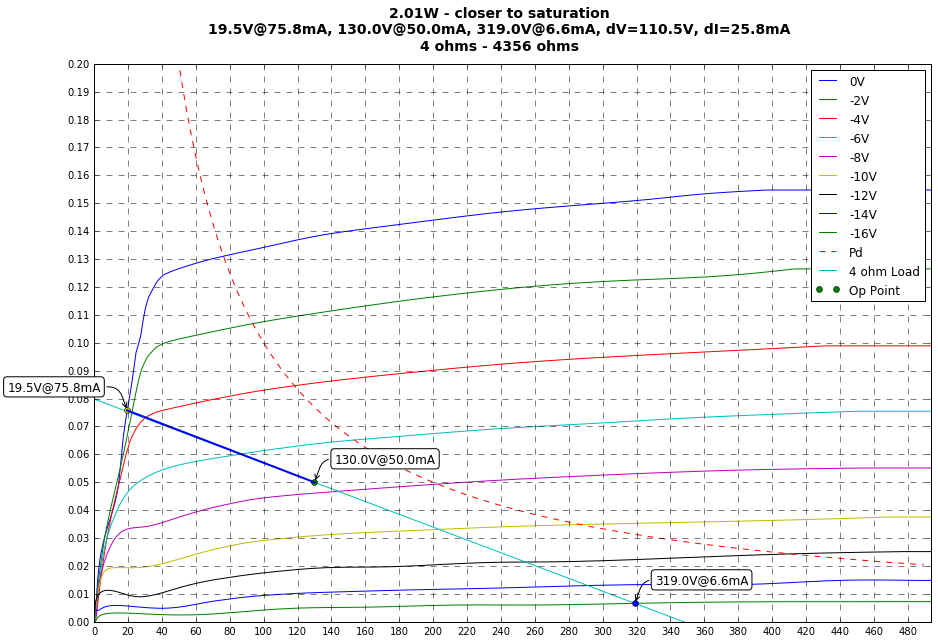

In [102]:
#initial values
Ia = 0.05  #plate current mA
Va = 129   #plate voltage V
Rl = 4     #speaker impedance
n  = 33    #pri/sec turns ratio

# later, we find intersection of loadline with plate current curves by resampling
# so all have the same x values.
# http://stackoverflow.com/questions/17928452/find-all-intersections-of-xy-data-point-graph-with-numpy
# http://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html
va = np.arange(0, 490,0.5)
ia0f = interpolate.interp1d(df['AnodeVoltage'].tolist(), df['0V'].tolist())
ia16f = interpolate.interp1d(df['AnodeVoltage'].tolist(), df['-16V'].tolist())
ia0 = ia0f(va)
ia16 = ia16f(va)
cols = df.columns.values

def plot(Ia,Va,Rl,n):
    # plot the csv colums versus plate/anode voltage
    fig = plt.figure(figsize=(15, 10))
    null = [plt.plot(df[cols[0]],df[cols[x]],label=cols[x]) for x in range(1,len(cols))]
    plt.ylim(0,0.20)
    plt.grid(linestyle='--', linewidth=0.5)
    null = plt.xticks(np.arange(0,520,20))
    null = plt.yticks(np.arange(0,0.201,0.01))

    # plot power dissipation limit curve
    Pd = 10 # 10W
    null = plt.plot(va, Pd/va,label='Pd',linestyle='--')

    plateImpedance = float(Rl * n**2)

    m = -1/plateImpedance
    b = Ia + Va/plateImpedance
    ll = m*va+b

    null = plt.plot(va,ll,label='%d ohm Load'%Rl)
    null = plt.plot(Va,Ia, 'or',label='Op Point',color='g')

    ll = m*va+b

    mindiff = 10
    for v in va:
        diff = abs(ia0f(v)-(m*v+b))
        if diff < mindiff:
            v0intersect = v
            mindiff = diff

    mindiff = 10
    for v in va:
        diff = abs(ia16f(v)-(m*v+b))
        if diff < mindiff:
            v16intersect = v
            mindiff = diff

    i0intersect = ia0f(v0intersect)
    i16intersect = ia16f(v16intersect)
    
    null = plt.plot(v0intersect,i0intersect,'or',color='y')
    null = plt.plot(v16intersect,i16intersect,'or',color='b')
    
    dvlower = Va - v0intersect
    dilower = i0intersect - Ia
    dvhigher = v16intersect - Va
    dihigher = Ia - i16intersect
       
    if dvlower < dvhigher:
        # closer to saturation
        Pout =  dvlower*(1/math.sqrt(2))*dilower
        title = "%.2fW - closer to saturation\n%.1fV@%.1fmA, %.1fV@%.1fmA, %.1fV@%.1fmA, dV=%.1fV, dI=%.1fmA\n%d ohms - %d ohms"%(Pout,
                                                                            v0intersect,i0intersect*1000,
                                                                            Va,Ia*1000,
                                                                            v16intersect,i16intersect*1000,
                                                                            dvlower,dilower*1000,
                                                                            Rl,
                                                                            plateImpedance)
        null = plt.plot((v0intersect,Va),(i0intersect,Ia),linewidth=2,color='b')
    else:
        # closer to cutoff
        Pout =  (v16intersect-Va)*(1/math.sqrt(2))*(Ia-i16intersect)
        title = "%.2fW - closer to cutoff\n%.1fV@%.1fmA, %.1fV@%.1fmA, %.1fV@%.1fmA, dV=%.1fV, dI=%.1fmA\n%d ohms - %d ohms"%(Pout,
                                                                        v0intersect,i0intersect*1000,
                                                                        Va,Ia*1000,
                                                                        v16intersect,i16intersect*1000,
                                                                        dvhigher,dihigher*1000,
                                                                        Rl,
                                                                        plateImpedance)
        null = plt.plot((Va,v16intersect),(Ia,i16intersect),linewidth=2,color='b')

    null = plt.annotate(s="%.1fV@%.1fmA"%(v0intersect,i0intersect*1000),
                        xy=(v0intersect,i0intersect),
                        xycoords='data',
                        xytext=(-120,20),
                        textcoords='offset points',
                        bbox=dict(boxstyle="round", fc="1.0"),
                        size=12,
                        arrowprops=dict(arrowstyle="->",
                                        connectionstyle="angle,angleA=0,angleB=110,rad=10"))
    null = plt.annotate(s="%.1fV@%.1fmA"%(Va,Ia*1000),
                        xy=(Va,Ia),
                        xycoords='data',
                        xytext=(20,20),
                        textcoords='offset points',
                        bbox=dict(boxstyle="round", fc="1.0"),
                        size=12,
                        arrowprops=dict(arrowstyle="->",
                                        connectionstyle="angle,angleA=0,angleB=70,rad=10"))
    null = plt.annotate(s="%.1fV@%.1fmA"%(v16intersect,i16intersect*1000),
                        xy=(v16intersect,i16intersect),
                        xycoords='data',
                        xytext=(20,20),
                        textcoords='offset points',
                        bbox=dict(boxstyle="round", fc="1.0"),
                        size=12,
                        arrowprops=dict(arrowstyle="->",
                                        connectionstyle="angle,angleA=0,angleB=70,rad=10"))
    plt.suptitle(title,fontsize=14, fontweight='bold')
    plt.legend()

null = interact(plot,
             Ia=widgets.FloatSlider(min=0.01,max=0.1,step=0.005,value=Ia),
             Va=widgets.FloatSlider(min=50,max=300,step=10,value=130),
             Rl=widgets.FloatSlider(min=2,max=16,step=2,value=4),
             n=widgets.FloatSlider(min=10,max=40,step=1,value=33))